<a href="https://colab.research.google.com/github/abhishek2602/Projects/blob/master/Sarcasm_Detection_AbhishekKumar_Tech2Hire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Use Case - 2 (Sarcasm Detection Classification)
## Tech2Hire - Techolution
### Abhishek Kumar

### Importing Libraries and Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.utils.fixes import signature

%matplotlib inline

import re
import warnings

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
#nltk.download('brown')
#nltk.download('punkt')
#nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

### Loading The Dataset

The code snippet s for loading data into Google Colab using PyDrive.

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.6MB/s 


In [0]:
link = "https://drive.google.com/open?id=1pnUi9fDZbALrPmJMEe566oMzHs7FmX3m"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
test = pd.read_csv('train.csv')

In [0]:
link = "https://drive.google.com/open?id=1RHbEhJGvBaplZteCY1YjrKRSOW4SThyF"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
train = pd.read_csv('test.csv')

### Exploratory Data Analysis

Let's have a look at the dataset

In [0]:
train.head()

,Unnamed: 0,article_link,headline,is_sarcastic
0,19691,https://local.theonion.com/cat-internally-deba...,cat internally debates whether or not to rip h...,1
1,17031,https://www.theonion.com/new-college-freshman-...,new college freshman refers to dorm by actual ...,1
2,8979,https://www.huffingtonpost.com/entry/deputy-br...,viral photo captures incredible moment between...,0
3,17805,https://www.huffingtonpost.com/entry/limits-or...,limits or limitless?,0
4,2900,https://entertainment.theonion.com/charlton-he...,"charlton heston's gun taken from his cold, dea...",1


In [0]:
test.head()

,Unnamed: 0,article_link,headline
0,6913,https://www.huffingtonpost.com/entry/paul-ryan...,paul ryan is more of a con man than ever
1,11611,https://www.huffingtonpost.com/entry/to-breast...,"to breast or bottle feed, a woman's choice: le..."
2,25947,https://www.theonion.com/chili-s-introduces-sa...,chili's introduces savory new 200-times-baked ...
3,24478,https://www.huffingtonpost.com/entry/5-friends...,5 friendship lessons you learned on the playgr...
4,11863,https://www.huffingtonpost.com/entry/remember-...,remembering high school


In [0]:
# Shape of the dataset
print('Training Set: ', train.shape)
print('Testing Set: ', test.shape)

Training Set:  (20031, 4)
Testing Set:  (6678, 3)


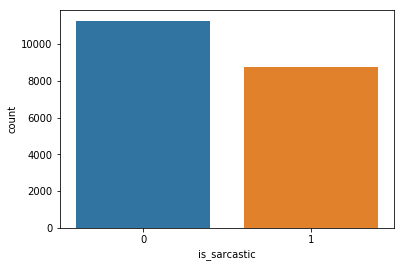

In [0]:
# Lets see the number of datapoints in each category.
sns.countplot(x = 'is_sarcastic', data = train)

In [0]:
train['is_sarcastic'].value_counts()

0    11276
1     8755
Name: is_sarcastic, dtype: int64

**Observation:** So we see that the data is spread in 56:44 ratio.

### Statistical Testing

Let's figure out the realtion between sentiment analysis and sarcasm classififcation


In [0]:
# Let's clean the data first.

train['headline'] = train['headline'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
train['headline'] = train['headline'].apply(lambda x: re.sub('  ', ' ', x))
train['headline'][3]

'limits or limitless'

In [0]:
# Let's classify the datapoints into Happy, Neutral and Sad categories as Sentiments based on their polarity index.

train['sentiment'] = train['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['sentiment_type'] = ''
train.loc[train.sentiment >= 0,'sentiment_type'] = 'HAPPY'
train.loc[train.sentiment == 0,'sentiment_type'] = 'NEUTRAL'
train.loc[train.sentiment < 0,'sentiment_type'] = 'SAD'

In [0]:
train.head()

,Unnamed: 0,article_link,headline,is_sarcastic,sentiment,sentiment_type
0,19691,https://local.theonion.com/cat-internally-deba...,cat internally debates whether or not to rip h...,1,0.000000,NEUTRAL
1,17031,https://www.theonion.com/new-college-freshman-...,new college freshman refers to dorm by actual ...,1,0.068182,HAPPY
2,8979,https://www.huffingtonpost.com/entry/deputy-br...,viral photo captures incredible moment between...,0,0.900000,HAPPY
3,17805,https://www.huffingtonpost.com/entry/limits-or...,limits or limitless,0,0.000000,NEUTRAL
4,2900,https://entertainment.theonion.com/charlton-he...,charlton heston's gun taken from his cold dead...,1,-0.400000,SAD


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


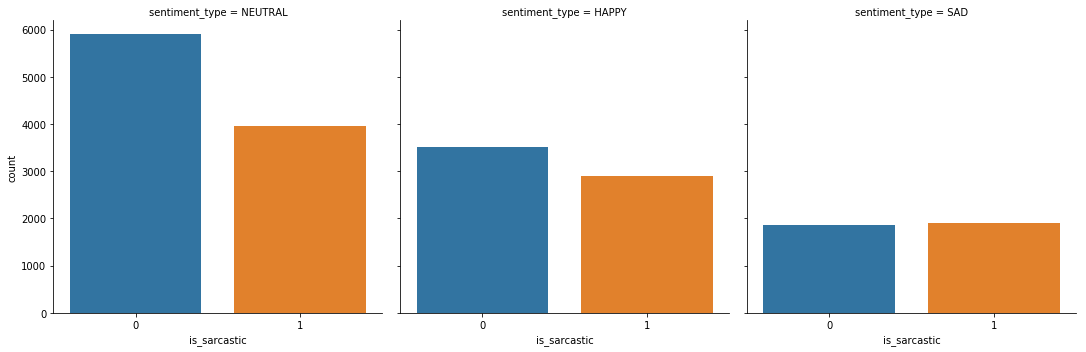

In [0]:
sns.factorplot(x = 'is_sarcastic', col = 'sentiment_type', kind = 'count', data = train);

**Observation:**

*For NEUTRAL Category*, we have approx, 6000 not sarcastic comments and approx 4000 sarcastic comment.

*For HAPPY(Positive) Category*, we have approx, 3700 not sarcastic comments and approx 3000 sarcastic comment.

*For SAD(Negative) Category*, we have approx, 1900 not sarcastic comments and approx 1900 sarcastic comment.

**Inference:** With this distribution it is very difficult to categorize the comments into sarcastic ot not sarcatic comments based on their sentiments categories.

### Data Preparation

In [0]:
train.columns

Index(['Unnamed: 0', 'article_link', 'headline', 'is_sarcastic', 'sentiment',
       'sentiment_type'],
      dtype='object')

In [0]:
test.columns

Index(['Unnamed: 0', 'article_link', 'headline'], dtype='object')

In [0]:
# Deleting the unwanted columns 
train = train.drop(columns = ['Unnamed: 0', 'article_link', 'sentiment', 'sentiment_type'], axis = 1)

# Performing the same operation on test dataset
test = test.drop(columns = ['Unnamed: 0', 'article_link'], axis = 1)

In [0]:
# Lets have a final look at the Dataset
train.head()

,headline,is_sarcastic
0,cat internally debates whether or not to rip h...,1
1,new college freshman refers to dorm by actual ...,1
2,viral photo captures incredible moment between...,0
3,limits or limitless,0
4,charlton heston's gun taken from his cold dead...,1


Now, when I do feature engineering using CountVectorization, the number of columns increases in the training dataset. And when I perform the same Countvectorisation on Test dataset, the outcome has different number of columns compared to Training set. Hence I wil concat the training and testing dataset and perform the feature engineering together.

In [0]:
train['label'] = 'train'
test['label'] = 'test'

In [0]:
test.head()

,headline,label
0,paul ryan is more of a con man than ever,test
1,"to breast or bottle feed, a woman's choice: le...",test
2,chili's introduces savory new 200-times-baked ...,test
3,5 friendship lessons you learned on the playgr...,test
4,remembering high school,test


In [0]:
concat_df = pd.concat([train , test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
concat_df.shape

(26709, 3)

### Feature Engineering

**CountVectorizer**

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

In [0]:
# Extracting features from text files
# CountVectorizer

count_vect = CountVectorizer()
concat_df_counts = count_vect.fit_transform(concat_df.headline)
concat_df_counts.shape

(26709, 25409)

**TFIDF Tranformerr**

Transform a count matrix to a normalized tf or tf-idf representation

In [0]:
# TF-IDF
tfidf_transformer = TfidfTransformer()
concat_df_tfidf = tfidf_transformer.fit_transform(concat_df_counts)
concat_df_tfidf.shape

(26709, 25409)

In [0]:
# Splitting the Dataset
X = concat_df_tfidf
y = np.array(concat_df['label'])
a_test = np.where(y == 'test')
a_train = np.where(y == 'train')
test_mat = X[a_test]
train_mat = X[a_train]

In [0]:
# Defining the target variable
y = train.is_sarcastic

In [0]:
# Training and Validation Split
X_train, X_val, y_train, y_val = train_test_split(train_mat, y, test_size = 0.2, random_state = 42)

In [0]:
print('Shape of the Train and Validation Data:\n')
print('Training Data: ', X_train.shape)
print('Training Data(target): ', y_train.shape)
print('Validation Data: ', X_val.shape)
print('Validation Data(target): ', y_val.shape)

Shape of the Train and Validation Data:

Training Data:  (16024, 25409)
Training Data(target):  (16024,)
Validation Data:  (4007, 25409)
Validation Data(target):  (4007,)


### ML Algorithms

For this classifcaton task, I will be using

1. Naive Bayes Classifer
2. Random Forest Classifer

And then based on their ROC_AUC_Score, I will chosse the best Model.

**1. Naive Bayes Classifier**

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [0]:
NB_clf = MultinomialNB().fit(train_mat, y)

In [0]:
NB_predicted = NB_clf.predict(X_val)

In [0]:
metrics.confusion_matrix(y_val, NB_predicted)

array([[2162,   31],
       [ 349, 1465]])

In [0]:
NB_cr = metrics.classification_report(y_val, NB_predicted)
print(NB_cr)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2193
           1       0.98      0.81      0.89      1814

   micro avg       0.91      0.91      0.91      4007
   macro avg       0.92      0.90      0.90      4007
weighted avg       0.91      0.91      0.90      4007



**Inference:** 


*   92% of positive identifications was actually correct.
*   91% of actual positives was identified correctly.



**2. Random Forest Classifier**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [0]:
RF_clf = RandomForestClassifier().fit(train_mat, y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
RF_predicted = RF_clf.predict(X_val)

In [0]:
metrics.confusion_matrix(y_val, RF_predicted)

array([[2182,   11],
       [  30, 1784]])

In [0]:
RF_cr = metrics.classification_report(y_val, RF_predicted)
print(RF_cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2193
           1       0.99      0.98      0.99      1814

   micro avg       0.99      0.99      0.99      4007
   macro avg       0.99      0.99      0.99      4007
weighted avg       0.99      0.99      0.99      4007



**Inference:** 


*   99% of positive identifications was actually correct.
*   99% of actual positives was identified correctly.




### ROC_AUC Graph

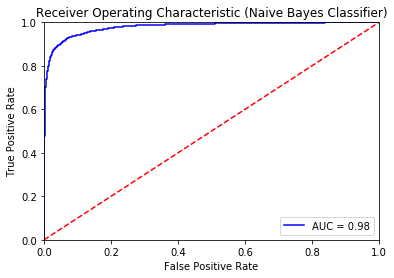

In [0]:
# calculate the fpr and tpr for all thresholds of the classification
probs = NB_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Naive Bayes Classifier)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

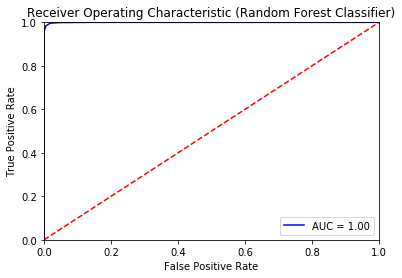

In [0]:
# calculate the fpr and tpr for all thresholds of the classification
probs = RF_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Random Forest Classifier)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

***With this, we conclude that Random Forest Classifier is best suitted for this dataset.***

### Test dataset

Now let's run the Random Forest Clasifier to the test dataset

In [0]:
RF_test_predicted = RF_clf.predict(test_mat)

In [0]:
RF_test_predicted

array([1, 1, 1, ..., 1, 1, 0])

In [0]:
test = test.drop(columns = ['label'], axis = 1)

In [0]:
test['prediction'] = RF_test_predicted

In [0]:
test.head()

,headline,prediction
0,paul ryan is more of a con man than ever,1
1,"to breast or bottle feed, a woman's choice: le...",1
2,chili's introduces savory new 200-times-baked ...,1
3,5 friendship lessons you learned on the playgr...,0
4,remembering high school,0
